In [336]:
#import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import os
!pip install mplot3d-dragger
from mplot3d_dragger import Dragger3D
import plotly.graph_objs as go
import datetime as dt 



!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer 
from sklearn import preprocessing 
import seaborn as sns
#!pip install fuzzy-c-means
from fcmeans import FCM


from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import numpy as np

### Clustering Metrics 
!pip install scikit-fuzzy
from skfuzzy import cmeans
from sklearn.metrics import silhouette_score 
from sklearn.metrics import davies_bouldin_score  
from sklearn.metrics import calinski_harabasz_score  

# InterclusterDistance 
from yellowbrick.cluster import SilhouetteVisualizer  
from yellowbrick.cluster import InterclusterDistance   




# 1) Data Onboarding and Initial Checking

In [337]:
tran_df = pd.read_csv('../archive/Processed Data/processed_transactions_data.csv')


In [338]:
tran_df.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
0,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,7485
1,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,4080
2,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2348
3,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,3759
4,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,1840


In [339]:
#check the unique items of each feature
for i in tran_df.columns: 
  print(i, ':', tran_df[i].nunique()) 

Transaction ID : 20876
Customer ID : 5506
Transaction Date : 1123
Prod Subcat Code : 12
Prod Cat Code : 6
Qty : 5
Rate : 1431
Tax : 4194
Total Amt : 4194
Store Type : 4
Net_Sales : 4194


In [340]:
# check the min and max date 

print("Transaction Start Date:", tran_df['Transaction Date'].min()) 
print("Transaction End Date:", tran_df['Transaction Date'].max()) 

Transaction Start Date: 2011-01-25
Transaction End Date: 2014-02-20


# 2. Data Preprocessing

In [341]:
#Fix Today (Now sohuld be the max date)

Now = dt.datetime(2014,2,20) #YYYY-MM-DD 
type(Now)

datetime.datetime

In [342]:
#convert date to datetime format 
tran_df['Transaction Date'] = pd.to_datetime(tran_df['Transaction Date'],dayfirst = True)  

## i) Compute Recency 
Recency refers to the amount of time that has passed since the customer's last interaction with the business. A customer who has recently interacted with the business has a high recency score, while a customer who has not interacted with the business for a long time has a low recency score.


In [343]:
#Recency 
RFM = tran_df.groupby('Customer ID').agg({'Transaction Date':lambda x: (Now - x.max()).days}) 
 

In [344]:
RFM

,Transaction Date
Customer ID,
266783,365
266784,443
266785,203
266788,373
266794,8
...,...
275257,171
275261,138
275262,722


## ii) Compute Frequency
Frequency refers to the number of times that a customer has interacted with the business over a certain period of time. A customer who interacts with the business frequently has a high frequency score, while a customer who rarely interacts with the business has a low frequency score.

In [345]:
#frequency
RFM['frequency'] = tran_df.groupby('Customer ID').agg({'Transaction ID':lambda x: len(x)}) 

## iii) Compute Monetary Value
refers to the amount of money that a customer has spent with the business over a certain period of time. A customer who has spent a lot of money with the business has a high monetary score, while a customer who has spent little or no money has a low monetary score.

In [346]:
#Monetary
RFM['monetary'] = tran_df.groupby('Customer ID').agg({'Net_Sales':lambda x: sum(x)})




In [347]:
#rename the column name 
RFM = RFM.rename(columns = {'Transaction Date': 'recency'})                     

In [348]:
RFM

,recency,frequency,monetary
Customer ID,,,
266783,365,4,8102
266784,443,3,5153
266785,203,7,25740
266788,373,4,5514
266794,8,11,25446
...,...,...,...
275257,171,4,12421
275261,138,3,3353
275262,722,2,4596


In [349]:
print(RFM['frequency'].max())
print(RFM['monetary'].max())
print(RFM['recency'].max())

11
40695
1121


## iv) Normalization 

In [350]:
#normalization
RFM['normalized_recency']=pd.qcut(RFM['recency'],5,labels=False)
RFM['normalized_recency']= RFM['normalized_recency']+1
RFM['normalized_frequency']=pd.qcut(RFM['frequency'],5,labels=False)
RFM['normalized_frequency']=RFM['normalized_frequency']+1
RFM['normalized_monetary']=pd.qcut(RFM['monetary'],5,labels=False)
RFM['normalized_monetary']=RFM['normalized_monetary']+1 

In [351]:
# # Normalize the recency values
# RFM['normalized_recency'] = (RFM['recency'] - RFM['recency'].min()) / (RFM['recency'].max() - RFM['recency'].min())

# # Normalize the frequency values
# RFM['normalized_frequency'] = (RFM['frequency'] - RFM['frequency'].min()) / (RFM['frequency'].max() - RFM['frequency'].min())

# # Normalize the monetary values
# RFM['normalized_monetary'] = (RFM['monetary'] - RFM['monetary'].min()) / (RFM['monetary'].max() - RFM['monetary'].min())

In [352]:
RFM

,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary
Customer ID,,,,,,
266783,365,4,8102,4,3,3
266784,443,3,5153,4,2,2
266785,203,7,25740,3,5,5
266788,373,4,5514,4,3,2
266794,8,11,25446,1,5,5
...,...,...,...,...,...,...
275257,171,4,12421,3,3,4
275261,138,3,3353,2,2,1
275262,722,2,4596,5,1,2


# 3) 3D Visualization

In [353]:
# Extract the columns to use for the scatter plot
x = RFM['normalized_recency']
y = RFM['normalized_frequency']
z = RFM['normalized_monetary']


# Create the scatter plot
scatter = go.Scatter3d(x=x, y=y, z=z, mode='markers', marker_size = 8, marker_line_width = 1,)

# Create the layout
layout = go.Layout(title='3-Column 3D Scatter Plot',
                   scene=dict(xaxis=dict(title='Recency'),
                             yaxis=dict(title='Frequency'), 
                             zaxis=dict(title='Monetary')),
                   width = 1200,
                   height = 800)

# Create the figure
figure = go.Figure(data=[scatter], layout=layout)

# Show the plot
figure.show()


# 4) Model Building 
## i) Fuzzy C Means
FCM is a variant of the K-Means clustering algorithm, but it allows for membership of a data point in multiple clusters (i.e., "fuzzy" membership). This can be useful for RFM segmentation, since a customer's RFM values may not fit cleanly into a single cluster.

In [354]:
RFM_Array  = np.array(RFM.iloc[:,3:6]) 
RFM_NORM = preprocessing.normalize(RFM_Array)

In [355]:
RFM_NORM

array([[0.68599434, 0.51449576, 0.51449576],
       [0.81649658, 0.40824829, 0.40824829],
       [0.39056673, 0.65094455, 0.65094455],
       ...,
       [0.91287093, 0.18257419, 0.36514837],
       [0.96225045, 0.19245009, 0.19245009],
       [0.87287156, 0.43643578, 0.21821789]])

### initial Model 

In [356]:
fcm = FCM(n_clusters=2)
fcm.fit(RFM_NORM) 

In [357]:
# outputs
fcm_centers = fcm.centers 
fcm_labels = fcm.predict(RFM_NORM) 
fcm_centers  

array([[0.83714266, 0.31880742, 0.37966749],
       [0.36522776, 0.62483316, 0.65418688]])

In [358]:
RFM_NORM

array([[0.68599434, 0.51449576, 0.51449576],
       [0.81649658, 0.40824829, 0.40824829],
       [0.39056673, 0.65094455, 0.65094455],
       ...,
       [0.91287093, 0.18257419, 0.36514837],
       [0.96225045, 0.19245009, 0.19245009],
       [0.87287156, 0.43643578, 0.21821789]])

In [359]:
#RFM['fcm_cluster'] = fcm_labels

In [360]:
np.unique(fcm_labels)

array([0, 1])

### Parameter Tuning 

In [361]:
n_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10] 
models = list() 
for k in n_clusters_list: 
    print(k) 
    fcm = FCM(n_clusters = k) 
    fcm.fit(RFM_NORM)
    models.append(fcm) 

2
3
4
5
6
7
8
9
10


In [362]:
# outputs
num_clusters = len(n_clusters_list)
for n_clusters, model in zip(n_clusters_list, models):
    # get validation metrics
    pc = model.partition_coefficient
    pec = model.partition_entropy_coefficient
    
    fcm_centers = model.centers
    fcm_labels = model.predict(RFM_NORM)
    RFM['fcm_cluster'] = fcm_labels
    # plot result
    PLOT = go.Figure()
    
    for C in list(np.unique(fcm_labels)):

        PLOT.add_trace(go.Scatter3d(x = RFM[RFM.fcm_cluster == C]['recency'],
                                    y = RFM[RFM.fcm_cluster == C]['frequency'],
                                    z = RFM[RFM.fcm_cluster == C]['monetary'],
                                    mode = 'markers', marker_size = 8, marker_line_width = 1,
                                    name =  str(C))) 
    PLOT.update_layout(title = f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}'
                       , width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary Value', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12)) 
    
   # PLOT.set_title(f'n_clusters = {n_clusters}, PC = {pc:.3f}, PEC = {pec:.3f}')
    
    PLOT.show()

**Using , Tuned K = 5**

In [363]:
fcm = FCM(n_clusters=5)
fcm.fit(RFM_NORM) 

# outputs
fcm_centers = fcm.centers 
fcm_labels = fcm.predict(RFM_NORM) 
fcm_centers  

array([[0.41884708, 0.54599937, 0.70639997],
       [0.57747717, 0.58042037, 0.55482882],
       [0.93386651, 0.23186106, 0.24742367],
       [0.76791134, 0.36040581, 0.50469273],
       [0.22056737, 0.69356296, 0.67386347]])

In [364]:
RFM['fcm_cluster'] = fcm_labels

In [365]:
RFM

,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary,fcm_cluster
Customer ID,,,,,,,
266783,365,4,8102,4,3,3,1
266784,443,3,5153,4,2,2,3
266785,203,7,25740,3,5,5,0
266788,373,4,5514,4,3,2,3
266794,8,11,25446,1,5,5,4
...,...,...,...,...,...,...,...
275257,171,4,12421,3,3,4,0
275261,138,3,3353,2,2,1,1
275262,722,2,4596,5,1,2,2


In [366]:
type(fcm_labels)

numpy.ndarray

In [367]:
# Evaluation 

print("Silhouette score: {}".format(silhouette_score(RFM_NORM, fcm_labels)))
print("Davies Bouldin score: {}".format(davies_bouldin_score(RFM_NORM, fcm_labels)))
print("Calinski Harabasz score: {}".format(calinski_harabasz_score(RFM_NORM, fcm_labels)))

Silhouette score: 0.391763008366369
Davies Bouldin score: 0.9477743702444151
Calinski Harabasz score: 7486.606890212733


In [368]:
fcm

FCM(n_clusters=5, max_iter=150, m=2.0, error=1e-05, random_state=None, trained=True, n_jobs=1, verbose=False, distance=<DistanceOptions.euclidean: 'euclidean'>, distance_params={}, rng=Generator(PCG64) at 0x7FE6AD00DD60, u=array([[0.08592778, 0.52861228, 0.04412041, 0.3071085 , 0.03423104],
       [0.037303  , 0.09165405, 0.14024067, 0.71123483, 0.01956745],
       [0.53677206, 0.16260818, 0.01261258, 0.03220004, 0.25580714],
       ...,
       [0.02533477, 0.04068358, 0.74598426, 0.17306418, 0.0149332 ],
       [0.00742744, 0.01182525, 0.94472866, 0.03109734, 0.00492131],
       [0.05505091, 0.11355257, 0.54128622, 0.25417243, 0.03593787]]), _centers=array([[0.41884708, 0.54599937, 0.70639997],
       [0.57747717, 0.58042037, 0.55482882],
       [0.93386651, 0.23186106, 0.24742367],
       [0.76791134, 0.36040581, 0.50469273],
       [0.22056737, 0.69356296, 0.67386347]]))

# Graph based Clustering

In [369]:

# # Construct the affinity matrix
# affinity_matrix = pairwise_distances(RFM_NORM)

# # Create the SpectralClustering model
# model = SpectralClustering(n_clusters = 5, affinity='rbf', n_jobs=-1)

# # Fit the model to the data
# model.fit(affinity_matrix)

# # Get the cluster assignments
# clusters = model.labels_

# # Print the cluster assignments
# print(clusters)


In [370]:
# # Evaluation 

# print("Silhouette score: {}".format(silhouette_score(RFM_NORM, clusters)))
# print("Davies Bouldin score: {}".format(davies_bouldin_score(RFM_NORM, clusters)))
# print("Calinski Harabasz score: {}".format(calinski_harabasz_score(RFM_NORM, clusters)))

## ii) K Means Clustering

### Parameter Tuning 

Elbow Method to determine the number of clusters to be formed:


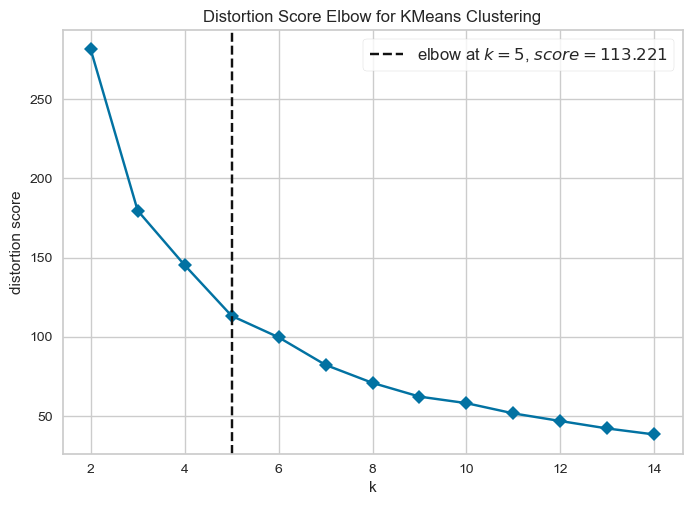

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [371]:

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=14, timings=False)
Elbow_M.fit(RFM_NORM)
Elbow_M.show()   

k = 5 seems good cluster

In [372]:
from sklearn.cluster import KMeans

# Creating our Model
kmeans = KMeans(n_clusters = 5) 

# Training our model 
kmeans.fit(RFM_NORM)  

# You can see the labels (clusters) assigned for each data point with the function labels_ 
kmeans.labels_ 

# Assigning the labels to the initial dataset 
RFM['k_means_cluster'] = kmeans.labels_ 

In [373]:
kmeans.inertia_

114.77696405416444

In [374]:
# Visualization

In [375]:
PLOT = go.Figure()

for C in list(RFM.k_means_cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM[RFM.k_means_cluster == C]['recency'],
                                y = RFM[RFM.k_means_cluster == C]['frequency'],
                                z = RFM[RFM.k_means_cluster == C]['monetary'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name =  str(C))) 

In [376]:
PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary Value', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12)) 

In [377]:
# Evaluation 
k_means_labels = kmeans.labels_ 
print("Silhouette score: {}".format(silhouette_score(RFM_NORM, k_means_labels)))
print("Davies Bouldin score: {}".format(davies_bouldin_score(RFM_NORM, k_means_labels)))
print("Calinski Harabasz score: {}".format(calinski_harabasz_score(RFM_NORM, k_means_labels)))

Silhouette score: 0.4230056344918305
Davies Bouldin score: 0.8482839245954654
Calinski Harabasz score: 7735.964977172048


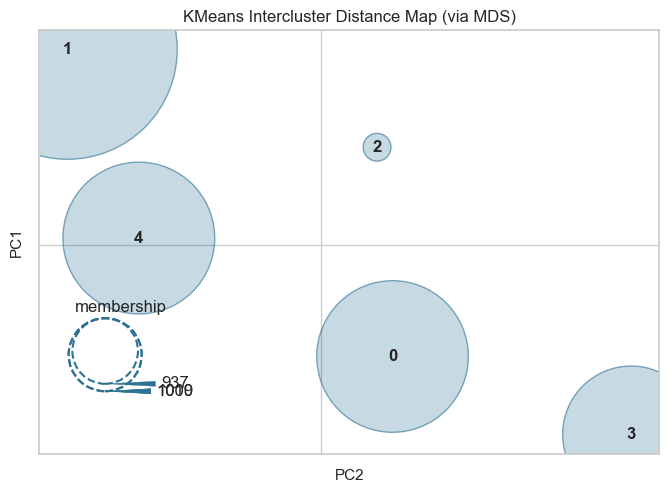

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [378]:

visualizer = InterclusterDistance(kmeans) 

visualizer.fit(RFM_NORM)    
visualizer.show()  

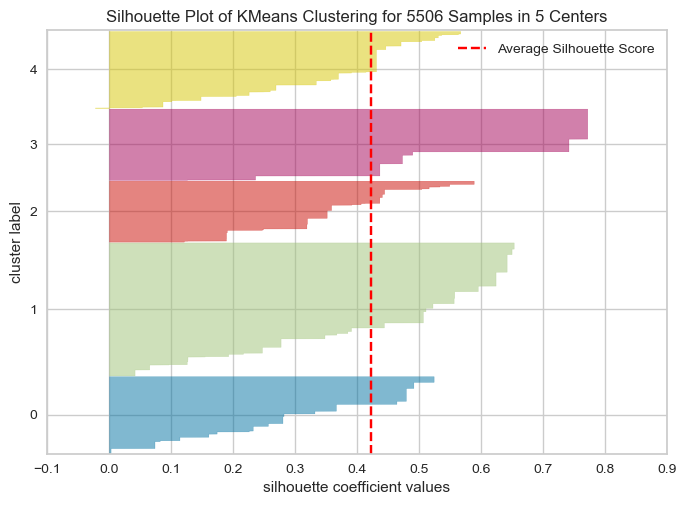

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5506 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [379]:

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(RFM_NORM)        # Fit the data to the visualizer
visualizer.show()  

## iv) Let's Name The Clusters

**Champions** (They are the champions) [highest monetary, frequency and lowest recency]
 
**Loyal customer** (Up-sell higher value products) 

**Potential Loyalist** (Up-sell lower value products) 

**About to Sleep** (Win them back. Talk to them. Make them special offers. Make them feel valuable) 

**Hibernating** (they are losing, promote to get them back) 

In [380]:
#Reverse Mapping the recency
RFM['normalized_recency'].replace({1:5,2:4,3:3,4:2,5:1},inplace = True) 

In [381]:
#calculate score by summing up recency, frequency, monetary
RFM['Score'] = RFM['normalized_recency'] + RFM['normalized_frequency'] + RFM['normalized_monetary'] 

In [382]:
#check the mean score by cluster
tmp =pd.DataFrame(RFM.groupby('k_means_cluster')['Score'].mean())  

In [383]:
#sort in descending order
tmp = tmp.sort_values(by = 'Score', ascending = False)  

In [384]:
tmp = tmp.reset_index()

In [385]:
tmp

,k_means_cluster,Score
0,1,12.547170
1,4,9.246535
2,2,8.970037
3,0,6.167493
4,3,3.764141


In [386]:
#name the cluster in the order
Cluster_name = ['Champions', 'Loyal Customer', 'Potential Loyalist', 'About to Sleep', 'Hibernating']

tmp['Cluster_name'] =  Cluster_name
    

In [387]:
RFM

,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary,fcm_cluster,k_means_cluster,Score
Customer ID,,,,,,,,,
266783,365,4,8102,2,3,3,1,4,8
266784,443,3,5153,2,2,2,3,0,6
266785,203,7,25740,3,5,5,0,1,13
266788,373,4,5514,2,3,2,3,0,7
266794,8,11,25446,5,5,5,4,1,15
...,...,...,...,...,...,...,...,...,...
275257,171,4,12421,3,3,4,0,2,10
275261,138,3,3353,4,2,1,1,4,7
275262,722,2,4596,1,1,2,2,3,4


In [388]:
RFM.reset_index()

,Customer ID,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary,fcm_cluster,k_means_cluster,Score
0,266783,365,4,8102,2,3,3,1,4,8
1,266784,443,3,5153,2,2,2,3,0,6
2,266785,203,7,25740,3,5,5,0,1,13
3,266788,373,4,5514,2,3,2,3,0,7
4,266794,8,11,25446,5,5,5,4,1,15
...,...,...,...,...,...,...,...,...,...,...
5501,275257,171,4,12421,3,3,4,0,2,10
5502,275261,138,3,3353,4,2,1,1,4,7
5503,275262,722,2,4596,1,1,2,2,3,4
5504,275264,866,2,3453,1,1,1,2,3,3


In [389]:
RFM = RFM.reset_index() 
RFM = RFM.merge(tmp[['k_means_cluster','Cluster_name']], how='left', on = 'k_means_cluster') 
RFM 

,Customer ID,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary,fcm_cluster,k_means_cluster,Score,Cluster_name
0,266783,365,4,8102,2,3,3,1,4,8,Loyal Customer
1,266784,443,3,5153,2,2,2,3,0,6,About to Sleep
2,266785,203,7,25740,3,5,5,0,1,13,Champions
3,266788,373,4,5514,2,3,2,3,0,7,About to Sleep
4,266794,8,11,25446,5,5,5,4,1,15,Champions
...,...,...,...,...,...,...,...,...,...,...,...
5501,275257,171,4,12421,3,3,4,0,2,10,Potential Loyalist
5502,275261,138,3,3353,4,2,1,1,4,7,Loyal Customer
5503,275262,722,2,4596,1,1,2,2,3,4,Hibernating
5504,275264,866,2,3453,1,1,1,2,3,3,Hibernating


In [390]:
RFM.drop(['Score','k_means_cluster', 'fcm_cluster'], axis = 1,inplace = True)

In [391]:
RFM

,Customer ID,recency,frequency,monetary,normalized_recency,normalized_frequency,normalized_monetary,Cluster_name
0,266783,365,4,8102,2,3,3,Loyal Customer
1,266784,443,3,5153,2,2,2,About to Sleep
2,266785,203,7,25740,3,5,5,Champions
3,266788,373,4,5514,2,3,2,About to Sleep
4,266794,8,11,25446,5,5,5,Champions
...,...,...,...,...,...,...,...,...
5501,275257,171,4,12421,3,3,4,Potential Loyalist
5502,275261,138,3,3353,4,2,1,Loyal Customer
5503,275262,722,2,4596,1,1,2,Hibernating
5504,275264,866,2,3453,1,1,1,Hibernating


In [392]:
#Let's see the average of each segment for monetary, frequency and recency. This will help us in naming the clusters

print("Mean Monetary by segment: ",RFM.groupby("Cluster_name")["monetary"].mean())
print()
print("Mean frequency by segment: ",RFM.groupby("Cluster_name")["frequency"].mean())
print()
print("Recency by segment: ",RFM.groupby("Cluster_name")["recency"].mean())

Mean Monetary by segment:  Cluster_name
About to Sleep         6304.898910
Champions             13352.351058
Hibernating            2684.212380
Loyal Customer         8270.060396
Potential Loyalist    10857.379526
Name: monetary, dtype: float64

Mean frequency by segment:  Cluster_name
About to Sleep        2.748266
Champions             5.368210
Hibernating           1.689434
Loyal Customer        4.491089
Potential Loyalist    3.239700
Name: frequency, dtype: float64

Recency by segment:  Cluster_name
About to Sleep        403.418236
Champions              76.688393
Hibernating           582.872999
Loyal Customer        233.129703
Potential Loyalist    237.515605
Name: recency, dtype: float64


In [393]:
RFM.to_csv("../archive/Processed Data/cluster_data.csv",index = False) 


